In [1]:
import torch
import sys, os
import argparse
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from sam_segment import predict_masks_with_sam
from lama_inpaint import inpaint_img_with_lama
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point

/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-22 06:07:47.612523: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 06:07:47.612567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 06:07:47.612595: E tensorflow/com

Detectron v2 is not installed


In [2]:

input_img = '../wim_data/train/images/2023-04-21_48.mp4#t=0.jpg'
point_labels = [1]
sam_model_type = "vit_h"
sam_ckpt = './pretrained_models/sam_vit_h_4b8939.pth'

In [3]:
def normalized_coordinate_to_absolute(norm_x, norm_y, image_width=1280, image_height=720):
    abs_x = int(norm_x * image_width)
    abs_y = int(norm_y * image_height)
    return [abs_x, abs_y]

### load labels from .txt

In [4]:
def extract_coordinates(txt_folder_path, img_folder_path):
    # 이미지 폴더에서 모든 파일명을 가져옴
    
    
    image_files = [f for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for img_file in image_files:
        txt_file = os.path.join(txt_folder_path, os.path.splitext(img_file)[0] + '.txt')

        # 해당 .txt 파일이 존재하는지 확인
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    class_id, x_center, y_center, width, height = line.strip().split()
                    print(f"Image: {img_file}, Class ID: {class_id}, X Center: {x_center}, Y Center: {y_center}")
        else:
            print(f"No annotation for image {img_file}")

In [5]:
img_folder_path =f'../wim_data/train/images/'
txt_folder_path = f'../wim_data/train/labels/'

In [6]:
image_files = [f for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
image_files

['2023-04-24_45.mp4#t=280.jpg',
 '2023-04-24_48.mp4#t=168.jpg',
 '2023-04-21_48.mp4#t=46.jpg',
 '2023-04-24_64.mp4#t=46.jpg',
 '2023-04-24_46.mp4#t=36.jpg',
 '2023-04-24_38.mp4#t=170.jpg',
 '2023-04-21_61.mp4#t=40.jpg',
 '2023-04-24_63.mp4#t=156.jpg',
 '2023-04-21_48.mp4#t=4.jpg',
 '2023-04-24_64.mp4#t=252.jpg',
 '2023-04-21_48.mp4#t=102.jpg',
 '2023-04-24_57.mp4#t=72.jpg',
 '2023-04-24_48.mp4#t=32.jpg',
 '2023-04-24_45.mp4#t=120.jpg',
 '2023-04-24_48.mp4#t=272.jpg',
 '2023-04-24_60.mp4#t=184.jpg',
 '2023-04-24_62.mp4#t=102.jpg',
 '2023-04-21_60.mp4#t=230.jpg',
 '2023-04-21_59.mp4#t=116.jpg',
 '2023-04-21_62.mp4#t=252.jpg',
 '2023-04-24_67.mp4#t=212.jpg',
 '2023-04-24_60.mp4#t=64.jpg',
 '2023-04-24_66.mp4#t=56.jpg',
 '2023-04-24_46.mp4#t=248.jpg',
 '2023-04-24_58.mp4#t=42.jpg',
 '2023-04-24_61.mp4#t=136.jpg',
 '2023-04-24_57.mp4#t=74.jpg',
 '2023-04-24_65.mp4#t=200.jpg',
 '2023-04-21_48.mp4#t=120.jpg',
 '2023-04-24_41.mp4#t=40.jpg',
 '2023-04-21_49.mp4#t=2.jpg',
 '2023-04-24_44.mp4#t=4

In [7]:
img_file = image_files[0]
txt_file = os.path.join(txt_folder_path, os.path.splitext(img_file)[0] + '.txt')
txt_file

'../wim_data/train/labels/2023-04-24_45.mp4#t=280.txt'

In [8]:
absolute_coordinates = []

with open(txt_file, 'r') as file:
    lines = file.readlines()
    for line in lines:
        class_id, x_center, y_center, width, height = line.strip().split()
        absolute_coordinates.append(normalized_coordinate_to_absolute(float(x_center), float(y_center)))
absolute_coordinates

[[591, 413],
 [793, 338],
 [801, 269],
 [828, 203],
 [663, 223],
 [718, 292],
 [566, 184],
 [521, 252],
 [599, 99],
 [762, 66],
 [744, 105],
 [418, 64],
 [459, 108]]

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img = load_img_to_array(img_folder_path+ img_file)
coordinates = np.array(absolute_coordinates)
point_labels = np.ones(len(absolute_coordinates))

In [10]:
masks, _, _ = predict_masks_with_sam(
        img,
        coordinates,
        point_labels,
        model_type=sam_model_type,
        ckpt_p=sam_ckpt,
        device=device,
    )

In [11]:
masks.shape

(3, 720, 1280)

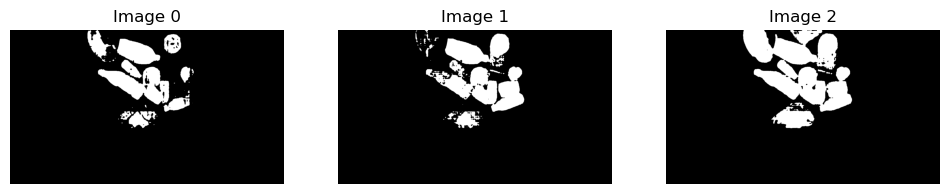

In [31]:
# 이미지의 개수
num_images = masks.shape[0]

# 한 번에 표시할 이미지의 개수
images_per_row = 3
%matplotlib inline
# 전체 이미지를 통해 반복
for i in range(0, num_images, images_per_row):
    plt.figure(figsize=(12, 4))
    for j in range(images_per_row):
        # 현재 인덱스 계산
        index = i + j
        if index < num_images:
            ax = plt.subplot(1, images_per_row, j + 1)
            img_to_show = masks[index].astype(int)
            ax.imshow(img_to_show, cmap='gray')  # 'gray' 컬러맵 사용
            #print(img_to_show)
            ax.title.set_text(f'Image {index}')
            plt.axis('off')
    plt.show()

In [32]:
masks = masks.astype(np.uint8)* 255

In [8]:
mask = masks[2]

In [33]:
import datetime
import albumentations as A

now = datetime.datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S")

# 폴더명 형식: "models_YYYYMMDD_HHMMSS"
folder_mask = f"./results/mask_{date_time}"
# 폴더명 형식: "models_YYYYMMDD_HHMMSS"
folder_inpainted = f"./results/mask_inpained_{date_time}"

# 폴더 생성 (이미 존재하지 않는 경우)
if not os.path.exists(folder_mask):
    os.makedirs(folder_mask)
# 폴더 생성 (이미 존재하지 않는 경우)
if not os.path.exists(folder_inpainted):
    os.makedirs(folder_inpainted)

lama_config = 'lama/configs/prediction/default.yaml'
lama_ckpt = './pretrained_models/big-lama'

In [17]:
# Declare an augmentation pipeline
transform = A.Compose([
    A.RandomBrightnessContrast(always_apply=True, p=1.0, brightness_limit=(1,1), contrast_limit=(1.0, 1.0), brightness_by_max=False),
])

In [20]:
def draw_two_images(image1, image2):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.imshow(image1)
    ax1.axis('off')  # 첫 번째 서브플롯의 축 제거
    
    # Display the image with bounding boxes
    ax2.imshow(image2)
    ax2.axis('off')  # 첫 번째 서브플롯의 축 제거
    plt.show()


In [18]:
img = transform(image=img)['image']

In [34]:
for idx, mask in enumerate(masks):
    mask_p =  f"{folder_mask}/mask_{idx}.png"
    img_inpainted_p = f"{folder_inpainted}/inpainted_{idx}.png"
    img_inpainted = inpaint_img_with_lama(
        img, mask, lama_config, lama_ckpt, device=device)
    save_array_to_img(img_inpainted, img_inpainted_p)
    save_array_to_img(mask, mask_p)
    

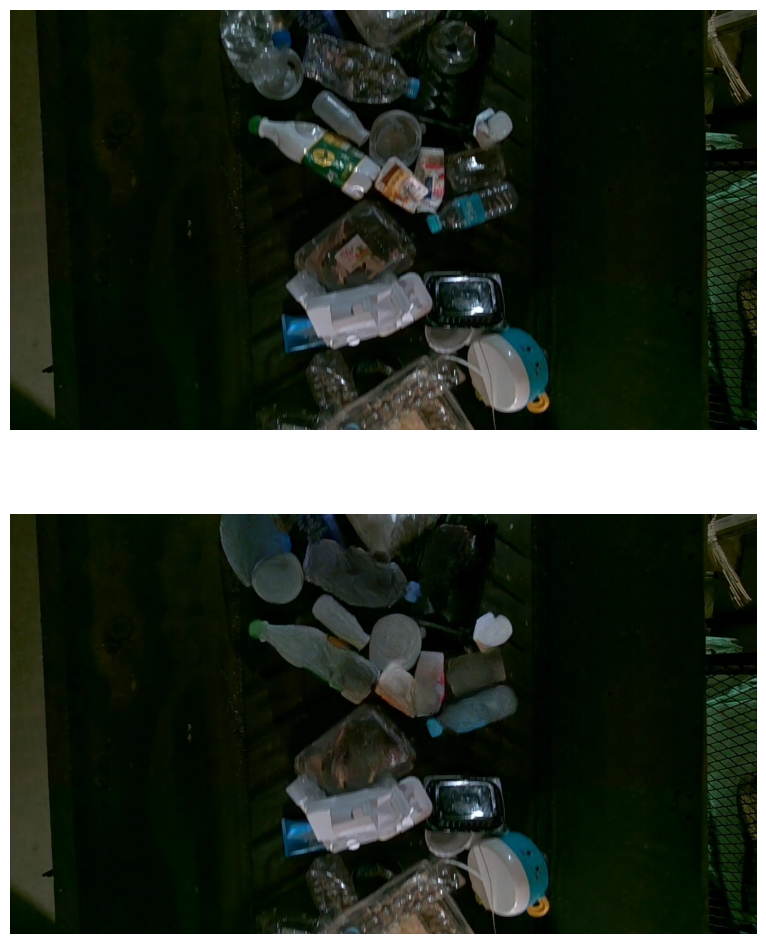

In [26]:
draw_two_images(img, img_inpainted)

In [12]:
img_inpainted

array([[[ 0, 22,  1],
        [ 0, 22,  1],
        [ 0, 22,  1],
        ...,
        [21, 39,  1],
        [21, 37,  0],
        [21, 37,  0]],

       [[ 0, 22,  1],
        [ 0, 22,  1],
        [ 0, 22,  1],
        ...,
        [22, 40,  0],
        [21, 39,  1],
        [21, 39,  1]],

       [[ 0, 22,  1],
        [ 0, 22,  1],
        [ 0, 22,  1],
        ...,
        [26, 44,  4],
        [26, 42,  3],
        [26, 42,  5]],

       ...,

       [[42, 55,  2],
        [42, 55,  2],
        [42, 55,  2],
        ...,
        [ 0,  2,  0],
        [ 0,  2,  0],
        [ 1,  1,  0]],

       [[42, 55,  2],
        [42, 55,  2],
        [42, 55,  2],
        ...,
        [ 4, 11,  4],
        [ 4, 11,  4],
        [ 4, 11,  4]],

       [[42, 55,  2],
        [42, 55,  2],
        [42, 55,  2],
        ...,
        [28, 55, 36],
        [30, 55, 36],
        [28, 55, 36]]], dtype=uint8)